<h1> Projeto Data Warehouse Olist </h1>

<h2>Introdução</h2>

<p>
Este projeto tem como objetivo a construção de um data warehouse com base em um banco de dados relacional e comparar a performance de consultas entre as diferentes abordagens de modelagem de dados. Os dados utilizados são do dataset de e-commerce disponibilizado pela Olist no Kaggle e pode ser acessado através deste <a href='https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?datasetId=55151&sortBy=voteCount&sort=votes&select=olist_geolocation_dataset.csv'>link</a>. A modelagem do banco relacional seguiu a proposta disponibilizada no Kaggle, conforme abaixo:</a>
</p>


<div>
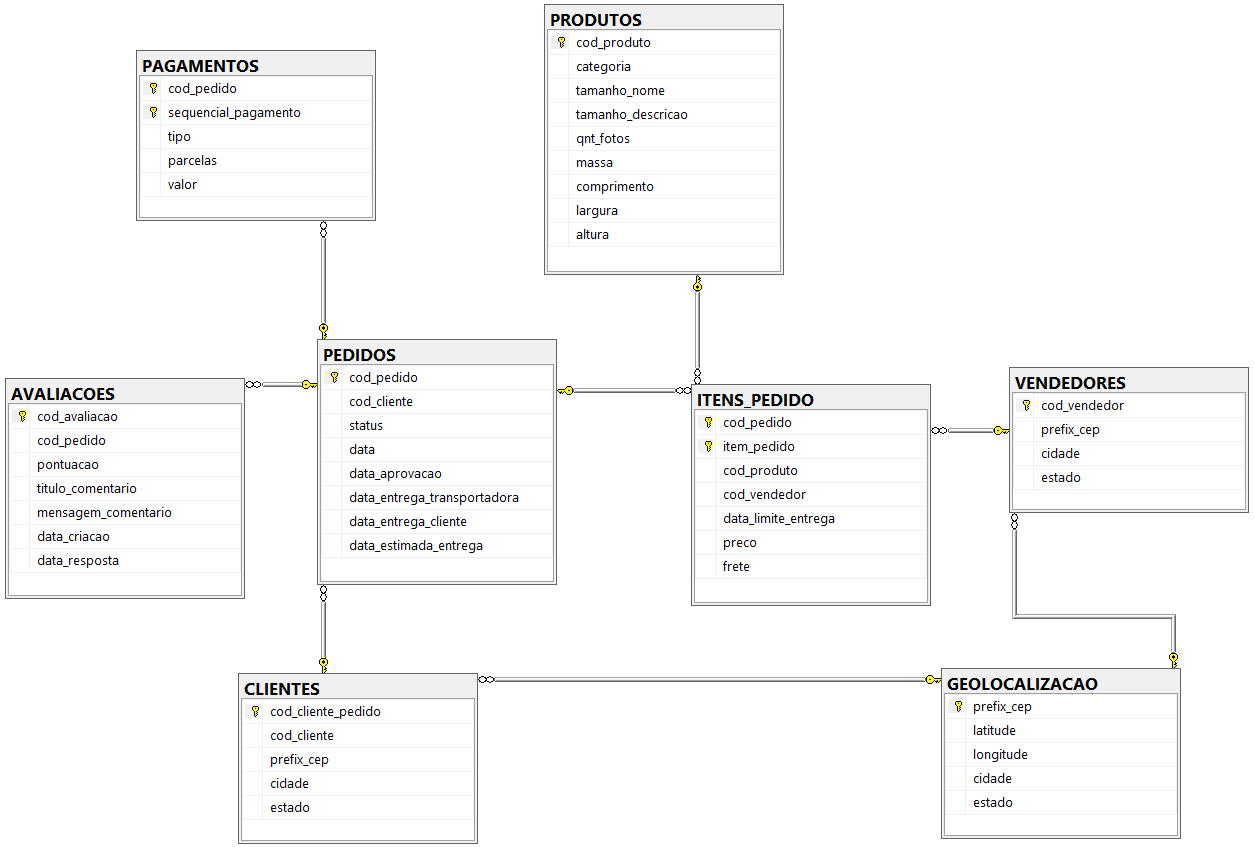
</div>

<p>
    A partir dos arquivos CSV foi construido um ETL para a construção de um banco de dados relacional utilizando o script em Python descrito abaixo. Estabelecendo conexão com o SQL Server, foram criadas as tabelas com as devidas chaves primárias e estrangeiras , posteriormente, o tratamento de valores nulos e carregamento dos dados.
</p>

<p>
    Com o banco relacional criado, foi utilizada a ferramenta on-premise SQL Server Service Integration (SSIS) para a criação do ETL do data warehouse consumindo dados do banco de dados recém criado. O modelo lógico do data warehouse é descrito na imagem abaixo: 
</p>

<div>
    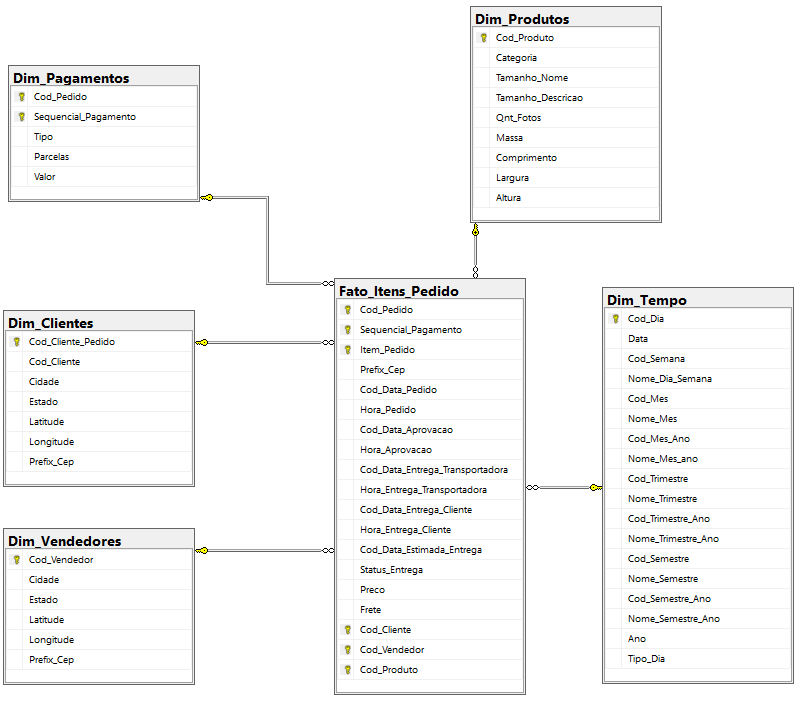
</div>

<p>
    Após a implementação dos dois bancos com diferentes abordagem de modelagem, mediu-se a performance de consulta para um determidado indicador e verificou-se a melhor performance do modelo dimensional conforme diretrizes propostas por Ralph Kimball em seu livro <a href='https://www.amazon.com.br/Data-Warehouse-Toolkit-Definitive-Dimensional-ebook/dp/B00DRZX6XS/ref=sr_1_1?qid=1668083125&refinements=p_27%3ARalph+Kimball&s=books&sr=1-1&ufe=app_do%3Aamzn1.fos.fcd6d665-32ba-4479-9f21-b774e276a678'>The Data Warehouse Toolkit: The Definitive Guide to Dimensional Modeling</a>
</p>

<h2>ETL Banco Relacional Olist</h2>

In [1]:
# Manipulação dos dados
import pandas as pd

# Tratamento de Strings
from unidecode import unidecode

# Tratamento de dados do tipo datetime
from datetime import datetime

# Conexão Python com SQLServer
import pyodbc

<h3> Conexão com SQL Server </h3>

In [2]:
# Conexão com o banco de dados on-premise
cnxn_str = ("DRIVER={SQL Server Native Client 11.0};"
            "SERVER=DESKTOP-0NS6QID;"
            "DATABASE=RELACIONAL_OLIST;"
            "UID=sa;"
            "PWD=**********")

cnxn = pyodbc.connect(cnxn_str)

# Criação do cursor para executar os comandos SQL
cursor = cnxn.cursor()

<h3> Tabela Produtos</h3>

In [12]:
# Carga dos dados
produtos = pd.read_csv("data_olist/olist_products_dataset.csv")

# Checagem dos valores nulos
produtos.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [13]:
# Tratamento dos valores categóricos nulos
produtos["product_category_name"] = produtos["product_category_name"].fillna("sem categoria")

produtos.isnull().sum()

product_id                      0
product_category_name           0
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [14]:
# Tratamento dos valores numéricos nulos
numericos = ["product_name_lenght",
             "product_description_lenght",
             "product_photos_qty",
             "product_weight_g",
             "product_length_cm",
             "product_height_cm",
             "product_width_cm"]

produtos[numericos] = produtos[numericos].fillna(0)
produtos.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [8]:
# Criação da tabela Produtos no SQL
cursor.execute('''
                CREATE TABLE [PRODUTOS] (
                  [cod_produto] CHAR(32) NOT NULL, 
                  [categoria] VARCHAR(50) NULL, 
                  [tamanho_nome] INT NULL, 
                  [tamanho_descricao] INT NULL, 
                  [qnt_fotos] INT NULL, 
                  [massa] INT NULL, 
                  [comprimento] INT NULL, 
                  [largura] INT NULL, 
                  [altura] INT NULL, 
                  CONSTRAINT [PK_PRODUTOS] PRIMARY KEY CLUSTERED (cod_produto)
                );
                ''')

# Carga dos dados na tabela Produtos
for row in produtos.itertuples():
    cursor.execute('''INSERT INTO PRODUTOS (
                          cod_produto, categoria, tamanho_nome, 
                          tamanho_descricao, qnt_fotos, massa, 
                          comprimento, largura, altura
                        ) 
                        VALUES 
                          (?, ?, ?, ?, ?, ?, ?, ?, ?)

                   ''',
                   row.product_id, 
                   row.product_category_name,
                   row.product_name_lenght,
                   row.product_description_lenght,
                   row.product_photos_qty,
                   row.product_weight_g,
                   row.product_length_cm,
                   row.product_width_cm,
                   row.product_height_cm
                  )
    

cursor.commit()

<h3> Tabela Avaliações</h3>

In [15]:
# Carga dos dados de avaliação
avaliacoes = pd.read_csv("data_olist/olist_order_reviews_dataset.csv", encoding='utf_8')

# Checagem dos valores nulos
avaliacoes.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [17]:
# Colunas com valores nulos
null_columns = ['review_comment_message', 'review_comment_title']

# Tratamento dos dados tipo string
avaliacoes[null_columns] = avaliacoes[null_columns].fillna("sem conteudo")
avaliacoes["review_comment_message"] = avaliacoes["review_comment_message"].apply(lambda x : x.replace("\r\n",' '))
avaliacoes["review_comment_message"] = avaliacoes["review_comment_message"].apply(lambda x : x.replace(",",';'))
avaliacoes["review_comment_message"] = avaliacoes["review_comment_message"].apply(lambda x : unidecode(x).lower())
avaliacoes["review_comment_message"] = avaliacoes["review_comment_message"].apply(lambda x : x.replace("'",""))
avaliacoes["review_comment_title"] = avaliacoes["review_comment_title"].apply(lambda x : unidecode(x).lower())
avaliacoes = avaliacoes.groupby('review_id').first().reset_index()

# Checagem dos valores nulos
avaliacoes.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

In [11]:
# Criação da tabela Avaliações
cursor.execute('''
                CREATE TABLE [AVALIACOES](
                    [cod_avaliacao] CHAR(32) NOT NULL,
                    [cod_pedido] CHAR(32) NULL,
                    [pontuacao] INT NULL,
                    [titulo_comentario] NVARCHAR(100) NULL,
                    [mensagem_comentario] NVARCHAR(500) NULL,
                    [data_criacao] SMALLDATETIME NULL,
                    [data_resposta] SMALLDATETIME NULL,
                    CONSTRAINT [PK_AVALIACOES] PRIMARY KEY CLUSTERED (cod_avaliacao)
                );
                ''')

# Carga dos dados na tabela Avaliações
for row in avaliacoes.itertuples():
    cursor.execute('''INSERT INTO AVALIACOES
                          (cod_avaliacao,cod_pedido,pontuacao,titulo_comentario,
                          mensagem_comentario,data_criacao,data_resposta)   
                      VALUES(?,?,?,?,?,?,?)
                   ''',
                   row.review_id, 
                   row.order_id,
                   row.review_score,
                   row.review_comment_title,
                   row.review_comment_message,
                   row.review_creation_date,
                   row.review_answer_timestamp
                  )
    

cursor.commit()

<h3> Tabela Clientes </h3>

In [18]:
# Carga dos dados de Clientes
clientes = pd.read_csv("data_olist/olist_customers_dataset.csv", dtype='str')

# Checagem dos valores nulos
clientes.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [15]:
# Checagem dos valores de código do cliente duplicados
clientes.customer_id.duplicated().sum()

0

In [16]:
# Criação da tabela Clientes
cursor.execute('''
                CREATE TABLE [CLIENTES](
                    [cod_cliente_pedido] CHAR(32) NOT NULL,
                    [cod_cliente] CHAR(32) NULL,
                    [prefix_cep] CHAR(5) NULL,
                    [cidade] VARCHAR(50) NULL,
                    [estado] VARCHAR(50) NULL,
                    CONSTRAINT [PK_CLIENTES] PRIMARY KEY CLUSTERED (cod_cliente_pedido)
                );
                ''')

# Carga dos dados na tabela Clientes
for row in clientes.itertuples():
    cursor.execute('''INSERT INTO CLIENTES
                          (cod_cliente_pedido,
                          cod_cliente,
                          prefix_cep,
                          cidade,
                          estado)   
                      VALUES(?,?,?,?,?)
                   ''',
                   row.customer_id, 
                   row.customer_unique_id,
                   row.customer_zip_code_prefix,
                   row.customer_city,
                   row.customer_state)   

cursor.commit()

<h3> Tabela Geolocalização</h3>

In [20]:
# Determinação do tipo dos dados de geolocalização
types = {'geolocation_zip_code_prefix':'str',
         'geolocation_lat': 'float',
         'geolocation_lng': 'float',
         'geolocation_state': 'str',
         'geolocation_city': 'str',
         'geometry': 'str'}

# Carga dos dados de geolocalização
geo = pd.read_csv("data_olist/olist_geolocation_dataset_transformed.csv", dtype=types)

# Checagem dos valores nulos
geo.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_state              0
geolocation_city               0
geometry                       0
dtype: int64

In [22]:
# Tratamento dos dados do tipo sting
geo['geolocation_state'] = geo['geolocation_state'].apply(lambda x: unidecode(x).lower())
geo['geolocation_city'] = geo['geolocation_city'].apply(lambda x: x.replace(",", ""))
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].apply(lambda x: x.zfill(5)) 

# Reorganização da disposisão das colunas
geo = geo.set_index("geolocation_zip_code_prefix")
geo = geo[['geolocation_lat', 'geolocation_lng', 'geolocation_state','geolocation_city']]
geo = geo.groupby('geolocation_zip_code_prefix').first().reset_index()

In [20]:
# Criação da tabela Geolocalização
cursor.execute('''
                CREATE TABLE [GEOLOCALIZACAO](
                    [prefix_cep] CHAR(5) NOT NULL,
                    [latitude] FLOAT NULL,
                    [longitude] FLOAT NULL,
                    [cidade] VARCHAR(50) NULL,
                    [estado] VARCHAR(50) NULL,
                    CONSTRAINT [PK_GEOLOCALIZACAO] PRIMARY KEY CLUSTERED (prefix_cep)
                );
                ''')

# Carga dos dados na tabela Geolocalização
for row in geo.itertuples():
    cursor.execute('''INSERT INTO GEOLOCALIZACAO
                          (prefix_cep,
                          latitude,
                          longitude,
                          cidade,
                          estado)   
                      VALUES(?,?,?,?,?)
                   ''',
                   row.geolocation_zip_code_prefix, 
                   row.geolocation_lat,
                   row.geolocation_lng,
                   row.geolocation_city,
                   row.geolocation_state)

# Inserção registros que faltavam de cep dos vendedores
cursor.execute('''
                INSERT INTO GEOLOCALIZACAO (
                  prefix_cep, longitude, latitude, cidade, 
                  estado
                ) 
                VALUES 
                  (
                    '02285', -46.5678753, -23.431341, 
                    'sao paulo', 'sp'
                  ), 
                  (
                    '07412', -46.341797, -23.3994586, 
                    'aruja', 'sp'
                  ), 
                  (
                    '21941', -43.2438268, -22.8143993, 
                    'rio de janeiro', 'rj'
                  ), 
                  (
                    '37708', -46.4992939, -21.8124775, 
                    'pocos de caldas', 'mg'
                  ), 
                  (
                    '71551', -47.8679859, -15.7045682, 
                    'brasilia', 'df'
                  ), 
                  (
                    '72580', -47.9893173, -15.9924741, 
                    'brasilia', 'df'
                  ), 
                  (
                    '82040', -49.2056041, -25.3981577, 
                    'curitiba', 'pr'
                  ), 
                  (
                    '91901', -51.2589679, -30.1060653, 
                    'porto alegre', 'rs'
                  )
                ;
              ''')

# Inserção dos registros que faltavam do cadastro de clientes
cursor.execute('''
                INSERT INTO GEOLOCALIZACAO (prefix_cep, cidade, estado) 
                SELECT 
                  DISTINCT c.prefix_cep, 
                  c.cidade, 
                  c.estado 
                FROM 
                  [RELACIONAL_OLIST].[dbo].[CLIENTES] c 
                  LEFT JOIN [RELACIONAL_OLIST].[dbo].[GEOLOCALIZACAO] geo ON geo.prefix_cep = c.prefix_cep 
                WHERE 
                  geo.cidade IS NULL 
                  AND c.cidade <> 'parati'
                ''')
    

cursor.commit()

<h3> Tabela Vendedores</h3>

In [21]:
# Carga dos dados de Vendedores
vendedores = pd.read_csv("data_olist/olist_sellers_dataset.csv", dtype='str')

# Checagem dos valores nulos
vendedores.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [24]:
# Checagem dos valores de código de vendedore duplicados
vendedores.seller_id.duplicated().sum()

0

In [25]:
# Criação da tabela Vendedores
cursor.execute('''
                CREATE TABLE [VENDEDORES](
                    [cod_vendedor] CHAR(32) NOT NULL,
                    [prefix_cep] CHAR(5) NULL,
                    [cidade] VARCHAR(50) NULL,
                    [estado] CHAR(2) NULL,
                    CONSTRAINT [PK_VENDEDORES] PRIMARY KEY CLUSTERED (cod_vendedor)
                );
                ''')

# Carga dos dados na tabela Vendedores
for row in vendedores.itertuples():
    cursor.execute('''INSERT INTO VENDEDORES
                          (cod_vendedor,
                          prefix_cep,
                          cidade,
                          estado)   
                      VALUES(?,?,?,?)
                   ''',
                   row.seller_id, 
                   row.seller_zip_code_prefix,
                   row.seller_city,
                   row.seller_state)   

cursor.commit()

<h3> Tabela Pagamentos</h3>

In [28]:
# Carga dos dados de pagamentos
pagamentos = pd.read_csv("data_olist/olist_order_payments_dataset.csv")

# Checagem dos valores nulos
pagamentos.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

<p>
    A coluna sequencial pagamento delimita quantos tipos de pagamentos foram feitos para cada pedido, por exemplo, se um cliente pagou utilizando cartão de crédito e débito, a tabela pagamento terá registros únicos para cada tipo, diferenciando cada um deles pelo campo payment_sequential. Em alguns casos, existiam pagamentos que se iniciavam com payment_sequential = 2 ou = 3. O script abaixo conserta esta inconsistência nos dados
</p>

In [30]:
# Lista dos pagamentos iniciados com payment_sequential = 2
list_seq_2 = []

# Lista dos pagamentos iniciados com payment_sequential = 3
list_seq_3 = []

# Iteração entre os registros com payment_sequential = 2
for i in pagamentos[pagamentos.payment_sequential == 2].index:
    order_id = pagamentos.order_id.loc[i]
    # Checagem para determinar se o registro com payment_sequential = 2 era único
    if len(pagamentos[pagamentos.order_id == order_id]) == 1:
        # Adição à lista de registros com inconsistência
        list_seq_2.append(pagamentos[pagamentos.order_id == order_id].index)
    else:
        pass

# Iteração entre os registros com payment_sequential = 3
for i in pagamentos[pagamentos.payment_sequential == 3].index:
    order_id = pagamentos.order_id.loc[i]
    # Checagem para determinar se o registro com payment_sequential = 3 tinha 3 elementos
    if len(pagamentos[pagamentos.order_id == order_id]) == 2:
        # Adição à lista de registros com inconsistência
        list_seq_3.append(pagamentos[pagamentos.order_id == order_id].index)
    else:
        pass

# Alteração dos registros conforme regra de negócio
for i in list_seq_2:
    pagamentos.loc[i,'payment_sequential'] = 1
    
for i in range(len(list_seq_3)):
    seq = 1
    for j in list_seq_3[i]:
        pagamentos.loc[j,'payment_sequential'] = seq
        seq += 1

In [31]:
# Checagem dos valores duplicados para a chave primária composta
pagamentos[['order_id','payment_sequential']].duplicated().sum()

0

In [32]:
# Criação da tabela Pagamentos
cursor.execute('''
                CREATE TABLE [PAGAMENTOS](
                    [cod_pedido] CHAR(32) NOT NULL,
                    [sequencial_pagamento] INT NOT NULL,
                    [tipo] VARCHAR(50) NULL,
                    [parcelas] INT NULL,
                    [valor] FLOAT NULL,
                    CONSTRAINT [PK_PAGAMENTOS] PRIMARY KEY CLUSTERED (cod_pedido,sequencial_pagamento)
                );
                ''')

# Carga dos dados na tabela Pagamentos
for row in pagamentos.itertuples():
    cursor.execute('''INSERT INTO PAGAMENTOS
                          (cod_pedido,
                          sequencial_pagamento,
                          tipo,
                          parcelas,
                          valor)   
                      VALUES(?,?,?,?,?)
                   ''',
                   row.order_id, 
                   row.payment_sequential,
                   row.payment_type,
                   row.payment_installments,
                   row.payment_value)
    
# Inserção um registro faltante
cursor.execute('''INSERT INTO PAGAMENTOS(
                      cod_pedido, sequencial_pagamento, 
                      valor
                    ) 
                    VALUES 
                      (
                        'bfbd0f9bdef84302105ad712db648a6c', 
                        1, 134.97
                      )
                ''')

cursor.commit()

<h3>Tabela Pedidos</h3>

In [33]:
# Carga dos dados de Pedidos
pedidos = pd.read_csv("data_olist/olist_orders_dataset.csv")

# Chegagem de valores nulos
pedidos.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [34]:
# Tratamento de valores nulos
pedidos = pedidos.fillna(0)

# Checagem de valores nulos
pedidos.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [38]:
# Checagem de código de pedido duplicados
pedidos.order_id.duplicated().sum()

0

In [39]:
# Criação da tabela Pedidos
cursor.execute('''
                CREATE TABLE [PEDIDOS](
                    [cod_pedido] CHAR(32) NOT NULL,
                    [cod_cliente] CHAR(32) NULL,
                    [status] VARCHAR(20) NULL,
                    [data] SMALLDATETIME NULL,
                    [data_aprovacao] SMALLDATETIME NULL,
                    [data_entrega_transportadora] SMALLDATETIME NULL,
                    [data_entrega_cliente] SMALLDATETIME NULL,
                    [data_estimada_entrega] SMALLDATETIME NULL,
                    CONSTRAINT [PK_PEDIDOS] PRIMARY KEY CLUSTERED (cod_pedido)
                );
                ''')

# Carga dos dados na tabela Pedidos
for row in pedidos.itertuples():
    cursor.execute('''INSERT INTO PEDIDOS
                          (cod_pedido,
                          cod_cliente,
                          status,
                          data,
                          data_aprovacao,
                          data_entrega_transportadora,
                          data_entrega_cliente,
                          data_estimada_entrega)   
                      VALUES(?,?,?,?,?,?,?,?)
                   ''',
                   row.order_id, 
                   row.customer_id,
                   row.order_status,
                   row.order_purchase_timestamp,
                   row.order_approved_at,
                   row.order_delivered_carrier_date,
                   row.order_delivered_customer_date,
                   row.order_estimated_delivery_date)   

cursor.commit()

<h3>Tabela Itens Pedidos </h3>

In [40]:
# Carga dos dados de Itens Pedido
itens_pedido = pd.read_csv("data_olist/olist_order_items_dataset.csv")

# Checagem de valores nulos
itens_pedido.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [41]:
# Criação da tabela de Itens_Pedido
cursor.execute('''
                CREATE TABLE[ITENS_PEDIDO](
                    [cod_pedido] CHAR(32) NOT NULL,
                    [item_pedido] INT NOT NULL,
                    [cod_produto] CHAR(32) NOT NULL,
                    [cod_vendedor] CHAR(32) NOT NULL,
                    [data_limite_entrega] SMALLDATETIME NULL,
                    [preco] FLOAT NULL,
                    [frete] FLOAT NULL,
                    CONSTRAINT [PK_ITENS_PEDIDOS] PRIMARY KEY CLUSTERED (cod_pedido,item_pedido)
                );
                ''')

# Carga dos dados na tabela Itens Pedido
for row in itens_pedido.itertuples():
    cursor.execute('''INSERT INTO ITENS_PEDIDO
                          (cod_pedido,
                          item_pedido,
                          cod_produto,
                          cod_vendedor,
                          data_limite_entrega,
                          preco,
                          frete)   
                      VALUES(?,?,?,?,?,?,?)
                   ''',
                   row.order_id, 
                   row.order_item_id,
                   row.product_id,
                   row.seller_id,
                   row.shipping_limit_date,
                   row.price,
                   row.freight_value)   

cursor.commit()

<h3> Foreign Keys </h3>

In [42]:
# Criação das chaves estrangeiras conforme modelo relacional
cursor.execute('''
                ALTER TABLE [VENDEDORES] WITH CHECK ADD CONSTRAINT [FK_VENDEDORES_GEOLOCALIZACAO]
                FOREIGN KEY ([prefix_cep]) REFERENCES [GEOLOCALIZACAO] ([prefix_cep]);

                ALTER TABLE [CLIENTES] WITH CHECK ADD CONSTRAINT [FK_CLIENTES_GEOLOCALIZACAO]
                FOREIGN KEY ([prefix_cep]) REFERENCES [GEOLOCALIZACAO] ([prefix_cep]);

                ALTER TABLE [PEDIDOS] WITH CHECK ADD CONSTRAINT [FK_PEDIDOS_CLIENTES]
                FOREIGN KEY ([cod_cliente]) REFERENCES [CLIENTES] ([cod_cliente_pedido]);

                ALTER TABLE [AVALIACOES] WITH CHECK ADD CONSTRAINT [FK_AVALIACOES_PEDIDOS]
                FOREIGN KEY ([cod_pedido]) REFERENCES [PEDIDOS] ([cod_pedido]);

                ALTER TABLE [PAGAMENTOS] WITH CHECK ADD CONSTRAINT [FK_PAGAMENTOS_PEDIDOS]
                FOREIGN KEY ([cod_pedido]) REFERENCES [PEDIDOS] ([cod_pedido]);

                ALTER TABLE [ITENS_PEDIDO] WITH CHECK ADD CONSTRAINT [FK_ITENS_PEDIDO_PEDIDOS]
                FOREIGN KEY ([cod_pedido]) REFERENCES [PEDIDOS] ([cod_pedido]);

                ALTER TABLE [ITENS_PEDIDO] WITH CHECK ADD CONSTRAINT [FK_ITENS_PEDIDO_PRODUTOS]
                FOREIGN KEY ([cod_produto]) REFERENCES [PRODUTOS] ([cod_produto]);

                ALTER TABLE [ITENS_PEDIDO] WITH CHECK ADD CONSTRAINT [FK_ITENS_PEDIDO_VENDEDORES]
                FOREIGN KEY ([cod_vendedor]) REFERENCES [VENDEDORES] ([cod_vendedor]);
            ''')

cursor.commit()

<h3>Modelo de dados Relacional</h3>
<div>
    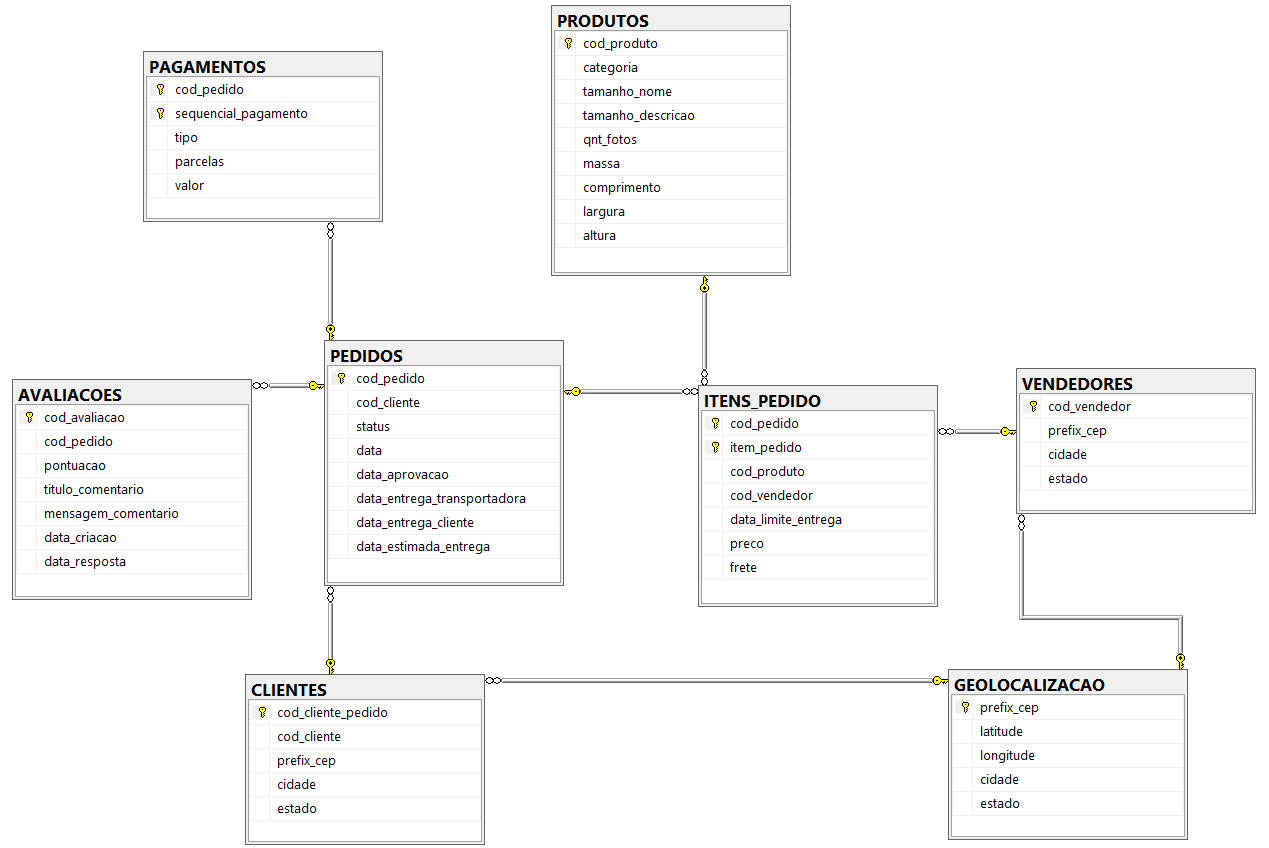
</div>

<h2>ETL do data warehouse Olist</h2>

<p>
   A modelagem do data warehouse foi feita conforme a matriz dimensão-indicador abaixo. Os conceitos foram retirados do livro <a href='https://www.amazon.com.br/Data-Warehouse-Toolkit-Definitive-Dimensional-ebook/dp/B00DRZX6XS/ref=sr_1_1?qid=1668083125&refinements=p_27%3ARalph+Kimball&s=books&sr=1-1&ufe=app_do%3Aamzn1.fos.fcd6d665-32ba-4479-9f21-b774e276a678'>The Data Warehouse Toolkit: The Definitive Guide to Dimensional Modeling</a> de Ralph Kimball.
</p>

<table>
    <tr>
        <td> </td>
        <td>Cliente</td>
        <td>Produto</td>
        <td>Pagamento</td>
        <td>Vendedor</td>
        <td>Tempo</td>
    </tr>
    <tr>
        <td>Unidades vendidas</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Valor da compra</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Custo de Frete</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Data</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Data Aprovação</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Data entrega p/ transportadora</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Data entrega p/ cliente</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Data estimada de entrega</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
    <tr>
        <td>Status da entrega</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
        <td>x</td>
    </tr>
</table>

<p>
   O ETL se divide basicamente entre a criação das tabelas e a carga dos dados. Estes dois processos serão descritos uma única vez, já que a criação de diferentes tabelas e a carga do dados não tem diferenças consideráveis nos processos.    
</p>

<h3>Criação do Projeto</h3>

<table>
    <td><img src="screenshots/1.jpg" width="250"/></td>
    <td><img src="screenshots/2.jpg" width="350"/></td>
</table>
    
<p>
    Clicando com o botão direito do mouse abre-se a janela de propriedades, seleciona-se a versão 2017 do SQL Server e habilita-se a opção que cria um scrip SQL a partir das modificações feitas no projeto.
</p>

<h3>Criação de Tabelas</h3>

<table>
    <td><img src="screenshots/3.jpg" width="400"/></td>
    <td><img src="screenshots/3.1.jpg" width="200"/></td>  
    <td><img src="screenshots/4.jpg" width="300"/></td>
</table>

<p>
    Para melhorar a organização, primeiro cria-se uma pasta para acomodar os scripts de criação de tabelas. Depois, clicando com o botão direito do mouse sobre a pasta recém criada, seleciona-se a opção de novo item. Um menu com diversas opções se apresentará e seleciona-se a opção nova tabela.
</p>

<table>
    <td><img src="screenshots/5.jpg" width="400"/></td>
    <td><img src="screenshots/6.jpg" width="250"/></td>
</table>

<p>
    Conforme a imagem acima, existe a possibilidade de criar as tabelas através de um assistente low code. Com as alterações cria-se automaticamente um script SQL correspondente. Os scripts utilizados na criação das tabelas podem ser verificados na próxima sessão deste artigo. Após finalizar, clica-se com o botão direito no projeto e na opção rebuild (recompilar) para verificar qualquer erro.
</p>

<table>
    <td><img src="screenshots/7.jpg" width="150"/></td>
    <td><img src="screenshots/8.jpg" width="400"/></td>
    <td><img src="screenshots/9.jpg" width="400"/></td>
</table>

<p>
    Não havendo nenhum erro após a recompilação, seleciona-se a opção publish (publicar) para aplicar as modificações no banco de dados SQL. Após estabelecer a conexão conforme imagem acima, as modificações já podem ser verificadas no SQL Server Management Studio.
</p>

<h4>Comandos SQL de criação das tabelas</h4>

```sql
-- Dimensão Cliente
CREATE TABLE [dbo].[Dim_Clientes]
(
	[Cod_Cliente_Pedido] CHAR(32) NOT NULL,
	[Cod_Cliente] CHAR(32) NULL,
	[Cidade] VARCHAR(50) NULL,
	[Estado] VARCHAR(50) NULL,
	[Latitude] FLOAT NULL,
	[Longitude] FLOAT NULL,
	[Prefix_Cep] CHAR(5) NULL,
	CONSTRAINT PK_CLIENTES PRIMARY KEY CLUSTERED (Cod_Cliente_Pedido)
)

-- Dimensão Pagamentos
CREATE TABLE [dbo].[Dim_Pagamentos]
(
	[Cod_Pedido] CHAR(32) NOT NULL,
	[Sequencial_Pagamento] INT NOT NULL,
	[Tipo] VARCHAR(50) NULL,
	[Parcelas] INT NULL,
	[Valor] FLOAT NULL,
	CONSTRAINT PK_PAGAMENTOS PRIMARY KEY CLUSTERED ([Cod_Pedido],[Sequencial_Pagamento])
)

-- Dimensão Produtos
CREATE TABLE [dbo].[Dim_Produtos]
(
	[Cod_Produto] CHAR(32) NOT NULL,
	[Categoria] VARCHAR(50) NULL,
	[Tamanho_Nome] INT NULL,
	[Tamanho_Descricao] INT NULL,
	[Qnt_Fotos] INT NULL,
	[Massa] INT NULL,
	[Comprimento] INT NULL,
	[Largura] INT NULL,
	[Altura] INT NULL,
	CONSTRAINT PK_PRODUTOS PRIMARY KEY CLUSTERED (Cod_Produto)
)

-- Dimensão Tempo
CREATE TABLE [dbo].[Dim_Tempo]
(
	[Cod_Dia] NVARCHAR(50) NOT NULL, 
    [Data] DATE NULL, 
    [Cod_Semana] INT NULL, 
    [Nome_Dia_Semana] NVARCHAR(50) NULL, 
    [Cod_Mes] INT NULL, 
    [Nome_Mes] NVARCHAR(50) NULL, 
    [Cod_Mes_Ano] NVARCHAR(50) NULL, 
    [Nome_Mes_ano] NVARCHAR(50) NULL, 
    [Cod_Trimestre] INT NULL, 
    [Nome_Trimestre] NVARCHAR(50) NULL, 
    [Cod_Trimestre_Ano] NVARCHAR(50) NULL, 
    [Nome_Trimestre_Ano] NVARCHAR(50) NULL, 
    [Cod_Semestre] INT NULL, 
    [Nome_Semestre] NVARCHAR(50) NULL, 
    [Cod_Semestre_Ano] NVARCHAR(50) NULL, 
    [Nome_Semestre_Ano] NVARCHAR(50) NULL, 
    [Ano] NVARCHAR(50) NULL, 
    [Tipo_Dia] NVARCHAR(50) NULL,
    CONSTRAINT PK_TEMPO PRIMARY KEY CLUSTERED ([Cod_Dia])
)

-- Dimensão Vendedores
CREATE TABLE [dbo].[Dim_Vendedores]
(
	[Cod_Vendedor] CHAR(32) NOT NULL,
	[Cidade] VARCHAR(50) NULL,
	[Estado] VARCHAR(50) NULL,
	[Latitude] FLOAT NULL,
	[Longitude] FLOAT NULL,
	[Prefix_Cep] CHAR(5) NULL,
	CONSTRAINT PK_VENDEDORES PRIMARY KEY CLUSTERED (Cod_Vendedor)
)

-- Fato Itens Pedido
CREATE TABLE [dbo].[Fato_Itens_Pedido]
(
	[Cod_Pedido] CHAR(32) NOT NULL,
	[Sequencial_Pagamento] INT NOT NULL,
	[Item_Pedido] INT NOT NULL,
	[Prefix_Cep] CHAR(5) NULL,
	[Cod_Data_Pedido] NVARCHAR(50) NULL,
	[Hora_Pedido] TIME NULL,
	[Cod_Data_Aprovacao] NVARCHAR(50) NULL,
	[Hora_Aprovacao] TIME NULL,
	[Cod_Data_Entrega_Transportadora] NVARCHAR(50) NULL,
	[Hora_Entrega_Transportadora] TIME NULL,
	[Cod_Data_Entrega_Cliente] NVARCHAR(50) NULL,
	[Hora_Entrega_Cliente] TIME NULL,
	[Cod_Data_Estimada_Entrega] NVARCHAR(50) NULL,
	[Status_Entrega] NVARCHAR(50) NULL,
	[Preco] FLOAT NULL,
	[Frete] FLOAT NULL,
	[Cod_Cliente] CHAR(32) NOT NULL,
	[Cod_Vendedor] CHAR(32) NOT NULL,
	[Cod_Produto] CHAR(32) NOT NULL,
	CONSTRAINT PK_FATO_ITENS_PEDIDO PRIMARY KEY CLUSTERED ([Cod_Pedido],[Item_Pedido],[Cod_Cliente],[Cod_Vendedor],[Cod_Produto],[Sequencial_Pagamento]), 
    CONSTRAINT [FK_Fato_Itens_Pedido_Dim_Cliente] FOREIGN KEY ([Cod_Cliente]) REFERENCES [Dim_Clientes]([Cod_Cliente_Pedido]), 
    CONSTRAINT [FK_Fato_Itens_Pedido_Dim_Produtos] FOREIGN KEY ([Cod_Produto]) REFERENCES [Dim_Produtos]([Cod_Produto]),
	CONSTRAINT [FK_Fato_Itens_Pedido_Dim_Pagamentos] FOREIGN KEY ([Cod_Pedido],[Sequencial_Pagamento]) REFERENCES [Dim_Pagamentos]([Cod_Pedido],[Sequencial_Pagamento]),
    CONSTRAINT [FK_Fato_Itens_Pedido_Dim_Vendedores] FOREIGN KEY ([Cod_Vendedor]) REFERENCES [Dim_Vendedores]([Cod_Vendedor]), 
    CONSTRAINT [FK_Fato_Itens_Pedido_Dim_Tempo] FOREIGN KEY ([Cod_Data_Pedido]) REFERENCES [Dim_Tempo]([Cod_Dia]),
)

```

<h3>Carga das tabelas</h3>

<table>
    <td><img src="screenshots/10.jpg" width="200"/></td>
    <td><img src="screenshots/11.jpg" width="200"/></td>
    <td><img src="screenshots/12.jpg" width="200"/></td>
</table>
    
<td><img src="screenshots/13.jpg" width="350"/></td>
    
<p>
    Para a carga dos dados nas tabelas se faz necessária a criação de um projeto do Integration Service dentro do Visual Studio. Clicando com o botão direito do mouse na solução do VS, cria-se o projeto conforme as imagens acima.
</p>

<table>
    <tr>
        <td colspan="3"><img src="screenshots/15.jpg" width="600"/></td>
    </tr>
    <tr>
        <td><img src="screenshots/14.jpg" width="150"/></td>
        <td><img src="screenshots/16.jpg" width="200"/></td>
        <td><img src="screenshots/17.jpg" width="400"/></td>
    </tr>
</table>

<p>
    No lado esquerdo do layout do Visual Studio ficam dispostas todas as ferramentas para a construção do ETL. No caso da carga, é necessário começar com um objeto de fluxo de dados, que habilita uma nova aba de fluxo de dados. Nesta nova aba inseri-se um assistente de origem dos dados, que pode ser um arquivo excel, flat file ou até uma conexão com um banco de dados. No caso, estabeleceu-se uma conexão com um banco de dados on premise SQL Server.
</p>

<table>
    <td><img src="screenshots/18.jpg" width="400"/></td>
    <td><img src="screenshots/19.jpg" width="400"/></td>
</table>

<p>
    Conforme a primeira imagem acima, se estabelece uma conexão com o banco de dados. Neste projeto optou-se pelo uso de consultas SQL para organizar as tabelas conforme a modelagem dimensional. Os comandos utilizados podem ser verificados na próxima sessão do artigo.
</p>

<table>
    <td><img src="screenshots/20.jpg" width="200"/></td>
    <td><img src="screenshots/21.jpg" width="400"/></td>
    <td><img src="screenshots/22.jpg" width="400"/></td>
</table>

<p>
    Optou-se pela ferramenta dimensão de alteração lenta para a carga dos dados pois permite a modificação de registro já existentes e impede erros de duplicação de chave primária. Esta ferramenta verifica os registros e, utilizando como parâmetro a chave primária da tabela (business key), possibilita a alteração de algum campo do registro.
</p>

<table>
    <td><img src="screenshots/24.jpg" width="400"/></td>
    <td><img src="screenshots/25.jpg" width="400"/></td>
</table>

<p>
    Para configurar a tabela destino dos dados, seleciona-se a conexão anteriormente estabelecida com o banco de dados da tabela a ser carregada. É importante se atentar ao mapeamento feito automaticamente dos campos da tabela origem para a tabela destino.
</p>

<table>
    <tr><img src="screenshots/23.jpg" width="500"/></tr>
    <tr><img src="screenshots/26.jpg" width="500"/></tr>
</table>

<p>
    Uma vez o fluxo criado, recompilamos o pacote de carga e, não havendo nenhum erro, selecionamos o play na barra de ferramentas no topo da tela.
</p>

<table>
    <td><img src="screenshots/27.1.jpg" width="500"/></td>
    <td><img src="screenshots/28.jpg" width="350"/></td>
</table>

<p>   
    Após a criação do fluxo de carregamento dos dados para cada uma das dimensões, podemos atrelar cada um destes fluxos de maneira que quando haja uma alteração de dados em alguma das dimensões, todo o processo de ETL seja novamente executado. Note que existe a separação em dois fluxos de carregamento, um para a tabelas de dimensões e outra para a tabela fato. Caso existi-se uma outra tabela fato no projeto, esta estaria no mesmo fluxo de dados da primeira.
</p>

<table>
    <tr>
        <td><img src="screenshots/29.jpg" width="250"/></td>
        <td><img src="screenshots/30.jpg" width="200"/></td>
        <td><img src="screenshots/31.jpg" width="500"/></td>
    </tr>
    <tr>
        <td colspan="3"><img src="screenshots/32.jpg" width="400"></td>
    </tr>
</table>


<p>
    Para automatizar o processo por completo, cria-se um novo pacote de carregamento que executa em série os pacotes de carregamento das dimensões e da tabela fato conforme imagem acima.
</p>

<h4>Consultas SQL para a carga do data warehouse</h4>

```sql
-- Fato Itens Pedido
SELECT
	ped.cod_pedido
	,pag.sequencial_pagamento
	,it.item_pedido
	,geo.prefix_cep
	,FORMAT(ped.data,'yyyyMMdd') AS cod_data_pedido
	,CAST(ped.data AS TIME(0)) AS hora_pedido
	,FORMAT(ped.data_aprovacao,'yyyyMMdd') AS cod_data_aprovacao
	,CAST(ped.data_aprovacao AS TIME(0)) AS hora_aprovacao
	,FORMAT(ped.data_entrega_transportadora,'yyyyMMdd' ) AS cod_data_entrega_transportadora
	,CAST(ped.data_entrega_transportadora AS TIME(0)) AS hora_entrega_transportadora
	,FORMAT(ped.data_entrega_cliente,'yyyyMMdd') AS cod_data_entrega_cliente
	,CAST(ped.data_entrega_cliente AS TIME(0)) AS hora_entrega_cliente
	,FORMAT(ped.data_estimada_entrega, 'yyyyMMdd') AS cod_data_estimada_entrega
	,ped.status
	,CASE WHEN pag.sequencial_pagamento = 1 THEN it.preco ELSE 0 END AS valor_item_pedido
	,CASE WHEN pag.sequencial_pagamento = 1 THEN it.frete ELSE 0 END AS frete_item_pedido
	,ped.cod_cliente
	,it.cod_vendedor
	,prod.cod_produto
FROM
	ITENS_PEDIDO it
LEFT JOIN
	PEDIDOS ped ON ped.cod_pedido = it.cod_pedido
LEFT JOIN
	PRODUTOS prod ON prod.cod_produto = it.cod_produto
LEFT JOIN
	PAGAMENTOS pag ON pag.cod_pedido = it.cod_pedido
LEFT JOIN
	(SELECT c.cod_cliente_pedido, geo.cidade, geo.estado, geo.latitude, geo.longitude, geo.prefix_cep 
	 FROM 
		CLIENTES c
	 INNER JOIN	
		GEOLOCALIZACAO geo ON c.prefix_cep = geo.prefix_cep) geo ON geo.cod_cliente_pedido = ped.cod_cliente
LEFT JOIN
	VENDEDORES vend ON vend.cod_vendedor = it.cod_vendedor

-- Dimensão Vendedores
SELECT 
	vend.cod_vendedor
	,geo.cidade
	,geo.estado
	,geo.latitude
	,geo.longitude
	,geo.prefix_cep
FROM 
	VENDEDORES vend
LEFT JOIN
	GEOLOCALIZACAO geo ON geo.prefix_cep = vend.prefix_cep

-- Dimensão Clientes
SELECT 
	c.cod_cliente_pedido
	,c.cod_cliente
	,geo.cidade
	,geo.estado
	,geo.latitude
	,geo.longitude
	,geo.prefix_cep
FROM 
	CLIENTES c
LEFT JOIN
	GEOLOCALIZACAO geo ON geo.prefix_cep = c.prefix_cep

-- Dimensão Produtos
SELECT * FROM PRODUTOS

-- Dimensão Pagamentos
SELECT * FROM PAGAMENTOS

-- Dimensão Tempo
DECLARE @DIMDATE TABLE
	(	[Cod_Dia] NVARCHAR(50) primary key, 
		[Data] DATE,
		[Cod_Semana] int,-- 01,02,03 .... 42,43,44
		[Nome_Dia_Semana] NVARCHAR(50),-- Segunda, terça, quarta, quinta, sexta
		[Cod_Mes] int,-- 01,02,03 ... , 11, 12
		[Nome_Mes] NVARCHAR(50),-- Janeiro, Fevereiro, Março, ... Novembro, Dezembro
		[Cod_Mes_Ano] NVARCHAR(50),-- 2017-01, 2017-02, ..., 2017-11, 2017-12
		[Nome_Mes_Ano] NVARCHAR(50),-- Janeiro 2017, Fevereiro 2017, ....
		[Cod_Trimestre] int,-- 01, 02, 03, 04
		[Nome_Trimestre] NVARCHAR(50),-- Primeiro Trimestre, Segundo Trimestre, ...
		[Cod_Trimestre_Ano] NVARCHAR(50),-- 2017-01, 2017-02, ...
		[Nome_Trimestre_Ano] NVARCHAR(50),-- Primeiro Trimestre 2017, Segundo Trimestre 2017, ...
		[Cod_Semestre] int,-- 01, 02, ...
		[Nome_Semestre] NVARCHAR(50),-- Primeiro Semestre, Segundo Semestre, ...
		[Cod_Semestre_Ano] NVARCHAR(50),-- 2017-01, 2017-02, ...
		[Nome_Semestre_Ano] NVARCHAR(50),-- Primeiro Semestre, Segundo Semestre, ...
		[Ano] NVARCHAR(50),-- 2017, ...
		[Tipo_Dia] NVARCHAR(50) -- Dia Útil ou Fim de Semana
	)

DECLARE @AnoInicial VARCHAR(4) = '2016'
DECLARE @MesInicial VARCHAR(2) = '1'
DECLARE @AnoFinal VARCHAR(4) = '2018'
DECLARE @MesFinal VARCHAR(2) = '12'

DECLARE @StartDate DATETIME
Select @StartDate = CAST(@AnoInicial + '/' + @MesInicial + '/01' AS DATETIME)

DECLARE @EndDate DATETIME 
SELECT @EndDate = DATEADD(month, ((CAST(@AnoFinal AS INTEGER) - 1900) * 12) + CAST(@MesFinal AS INTEGER), 0)

-- Variáveis temporárias para guardar valores durante o processo de cada ano.
DECLARE
	@DayOfWeekInMonth INT,
	@DayOfWeekInYear INT,
	@DayOfQuarter INT,
	@WeekOfMonth INT,
	@CurrentYear INT,
	@CurrentMonth INT,
	@CurrentQuarter INT

/*Tabela para armazenar o dia da semana para o mês e ano*/
DECLARE @DayOfWeek TABLE (DOW INT, MonthCount INT, QuarterCount INT, YearCount INT)

INSERT INTO @DayOfWeek VALUES (1, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (2, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (3, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (4, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (5, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (6, 0, 0, 0)
INSERT INTO @DayOfWeek VALUES (7, 0, 0, 0)

--Extrai e designa a parte da data para a variável

DECLARE @CurrentDate AS DATETIME = @StartDate
SET @CurrentMonth = DATEPART(MM, @CurrentDate)
SET @CurrentYear = DATEPART(YY, @CurrentDate)
SET @CurrentQuarter = DATEPART(QQ, @CurrentDate)

--Checagem de data atual menor que a data final especificado acima

WHILE @CurrentDate < @EndDate
BEGIN
 
/*Começo da lógica dia da semana*/

         /*Checagem da mudança de mês para a data atual, se o mês muda, muda-se o valor da variável*/
	IF @CurrentMonth != DATEPART(MM, @CurrentDate) 
	BEGIN
		UPDATE @DayOfWeek
		SET MonthCount = 0
		SET @CurrentMonth = DATEPART(MM, @CurrentDate)
	END

        /* Checagem de mudança de trimestre*/

	IF @CurrentQuarter != DATEPART(QQ, @CurrentDate)
	BEGIN
		UPDATE @DayOfWeek
		SET QuarterCount = 0
		SET @CurrentQuarter = DATEPART(QQ, @CurrentDate)
	END
       
        /* Checagem de mudança de ano*/
	

	IF @CurrentYear != DATEPART(YY, @CurrentDate)
	BEGIN
		UPDATE @DayOfWeek
		SET YearCount = 0
		SET @CurrentYear = DATEPART(YY, @CurrentDate)
	END
	
        -- Atribui valores conforme as variáveis acima 

	UPDATE @DayOfWeek
	SET 
		MonthCount = MonthCount + 1,
		QuarterCount = QuarterCount + 1,
		YearCount = YearCount + 1
	WHERE DOW = DATEPART(DW, @CurrentDate)

	SELECT
		@DayOfWeekInMonth = MonthCount,
		@DayOfQuarter = QuarterCount,
		@DayOfWeekInYear = YearCount
	FROM @DayOfWeek
	WHERE DOW = DATEPART(DW, @CurrentDate)
	
/*Fim da lógica dia da semana*/

/* Insere valores na tabela*/
	
	INSERT INTO @DIMDATE
	SELECT	
		CONVERT (NVARCHAR(8),@CurrentDate,112) as Cod_Dia,
		@CurrentDate as Data,
		RIGHT ('00'+LTRIM(STR(CONVERT(NVARCHAR(2), @DayOfWeekInYear))),2 ) as Cod_Semana,
		CASE DATEPART(DW, @CurrentDate)
			WHEN 1 THEN 'Domingo'
			WHEN 2 THEN 'Segunda'
			WHEN 3 THEN 'Terça'
			WHEN 4 THEN 'Quarta'
			WHEN 5 THEN 'Quinta'
			WHEN 6 THEN 'Sexta'
			WHEN 7 THEN 'Sábado'
			END 
			AS D_Nome_Dia_Semana,
        RIGHT ('00'+LTRIM(STR(CONVERT(NVARCHAR(2), DATEPART(MM, @CurrentDate)))),2 )  as Cod_Mes,
		CASE DATEPART(MM, @CurrentDate)
			WHEN 1 THEN 'Janeiro'
			WHEN 2 THEN 'Fevereiro'
			WHEN 3 THEN 'Março'
			WHEN 4 THEN 'Abril'
			WHEN 5 THEN 'Maio'
			WHEN 6 THEN 'Junho'
			WHEN 7 THEN 'Julho'
			WHEN 8 THEN 'Agosto'
			WHEN 9 THEN 'Setembro'
			WHEN 10 THEN 'Outubro'
			WHEN 11 THEN 'Novembro'
			WHEN 12 THEN 'Dezembro'
			END 
			AS D_Nome_Mes,
			RIGHT ('00'+LTRIM(STR(CONVERT(NVARCHAR(2), DATEPART(MM, @CurrentDate)))),2 ) + '-' + CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) as Cod_Mes_Ano,
			CASE DATEPART(MM, @CurrentDate)
			WHEN 1 THEN 'Janeiro'
			WHEN 2 THEN 'Fevereiro'
			WHEN 3 THEN 'Março'
			WHEN 4 THEN 'Abril'
			WHEN 5 THEN 'Maio'
			WHEN 6 THEN 'Junho'
			WHEN 7 THEN 'Julho'
			WHEN 8 THEN 'Agosto'
			WHEN 9 THEN 'Setembro'
			WHEN 10 THEN 'Outubro'
			WHEN 11 THEN 'Novembro'
			WHEN 12 THEN 'Dezembro'
			END + ' ' + CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) as D_Nome_Mes_Ano,
			RIGHT ('00'+LTRIM(STR(CONVERT(NVARCHAR(2), DATEPART(QQ, @CurrentDate)))),2 ) AS Cod_Trimestre,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN 'Primeiro Trimestre'
			WHEN 2 THEN 'Segundo Trimestre'
			WHEN 3 THEN 'Terceiro Trimestre'
			WHEN 4 THEN 'Quarto Trimestre'
			END AS D_Nome_Trimestre,
			RIGHT ('00'+LTRIM(STR(CONVERT(NVARCHAR(2), DATEPART(QQ, @CurrentDate)))),2 ) + '-' + 
			CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) as Cod_Trimestre_Ano,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN 'Primeiro Trimestre'
			WHEN 2 THEN 'Segundo Trimestre'
			WHEN 3 THEN 'Terceiro Trimestre'
			WHEN 4 THEN 'Quarto Trimestre'
			END + ' ' + CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) AS D_Nome_Trimestre_Ano,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN '01'
			WHEN 2 THEN '01'
			WHEN 3 THEN '02'
			WHEN 4 THEN '02'
			END 
			AS Cod_Semestre,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN 'Primeiro Semestre'
			WHEN 2 THEN 'Primeiro Semestre'
			WHEN 3 THEN 'Segundo Semestre'
			WHEN 4 THEN 'Segundo Semestre'
			END 
			AS D_Nome_Semestre,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN '01'
			WHEN 2 THEN '01'
			WHEN 3 THEN '02'
			WHEN 4 THEN '02'
			END + '-' + 
			CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) as Cod_Semestre_Ano,
			CASE DATEPART(QQ, @CurrentDate)
			WHEN 1 THEN 'Primeiro Semestre'
			WHEN 2 THEN 'Primeiro Semestre'
			WHEN 3 THEN 'Segundo Semestre'
			WHEN 4 THEN 'Segundo Semestre'
			END + ' ' + 
			CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) as D_Nome_Semestre_Ano,
			CONVERT(NVARCHAR(4), DATEPART(YEAR, @CurrentDate)) AS Ano,
			CASE DATEPART(DW, @CurrentDate)
			WHEN 1 THEN 'Fim de Semana'
			WHEN 2 THEN 'Dia Útil'
			WHEN 3 THEN 'Dia Útil'
			WHEN 4 THEN 'Dia Útil'
			WHEN 5 THEN 'Dia Útil'
			WHEN 6 THEN 'Dia Útil'
			WHEN 7 THEN 'Fim de Semana'
			END 
			AS Tipo_Dia

	SET @CurrentDate = DATEADD(DD, 1, @CurrentDate)
END

SELECT * FROM @DIMDATE order by Cod_Dia
```

<h3>Modelo de dados Multidimensional</h3>

<img src="screenshots/modelo_dimensional.jpg" width="700">   

<h2>Comparações</h2>

<p>
    As consultas abaixo retornam a quantidade de unidades vendidas por categoria de produto para o estado de São Paulo.
</p>

```sql
-- Modelo Multidimensional
SELECT 
  prod.Categoria
  ,COUNT(*) AS Unidades_vendidas 
FROM 
  [DW_OLIST].[dbo].[Fato_Itens_Pedido] itp 
  INNER JOIN [DW_OLIST].[dbo].[Dim_Produtos] prod ON prod.Cod_Produto = itp.Cod_Produto 
  INNER JOIN [DW_OLIST].[dbo].[Dim_Clientes] cli ON cli.Cod_Cliente_Pedido = itp.Cod_Cliente 
WHERE 
  cli.Estado = 'sp' 
GROUP BY 
  prod.Categoria 
ORDER BY 
  COUNT(*) DESC;
```  

<p>
    Podemos perceber que no modelo multidimensional as consultas são mais simples pois só existe relacionamento entre tabela fato e dimensão. Isto pode trazer um ganho na performance das consultas e alimentação de pipeline de modelos de data science quando tratamos de grandes volumes de dados. 
</p>

```sql
-- Modelo Relacional
SELECT 
  it_pr_ped.categoria
  ,COUNT(*) AS Unidades_vendidas
FROM 
  [RELACIONAL_OLIST].[dbo].[CLIENTES] cli 
  RIGHT JOIN (
    SELECT 
      it_prod.cod_produto, 
      ped.cod_pedido, 
      ped.cod_cliente, 
      ped.data, 
      it_prod.categoria, 
      it_prod.item_pedido, 
      it_prod.preco, 
      it_prod.frete 
    FROM 
      [RELACIONAL_OLIST].[dbo].[PEDIDOS] ped 
      RIGHT JOIN(
        SELECT 
          prod.categoria, 
          prod.cod_produto, 
          itns.item_pedido, 
          itns.cod_pedido, 
          itns.preco, 
          itns.frete 
        FROM
		  [RELACIONAL_OLIST].[dbo].[ITENS_PEDIDO] itns
          LEFT JOIN [RELACIONAL_OLIST].[dbo].[PRODUTOS] prod ON prod.cod_produto = itns.cod_produto
      ) it_prod ON ped.cod_pedido = it_prod.cod_pedido
  ) it_pr_ped ON it_pr_ped.cod_cliente = cli.cod_cliente_pedido
WHERE 
	cli.estado = 'SP'
GROUP BY 
	it_pr_ped.categoria
ORDER BY 
	COUNT(*) DESC;
```

<p>
    Já no modelo relacional temos que executar mais junções entre tabelas para obtermos o mesmo resultado devido a sua complexidade, isto também pode dificultar a integridade dos dados conforme escalamos o banco para gerir grandes volumes de dados.
</p>

<h2>Próximos passos</h2>

<p>
    A partir do banco de dados multidimensional será construido um banco OLAP (Online Analytical Processing) para alimentar uma fictícia área de negócios com indicadores propostos. Na sequencial será desenvolvido dashboards concluindo todo o pipeline de extração dos dados crus até a entrega de visualizações que ajudarão na tomada de decisões da área de negócios.
</p>